In [38]:
import os, sys, json
import imageio
import random
import pickle
import gc

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

from scipy.spatial.transform import Rotation, Slerp

from Nerfacito.Model import Voxels
from Nerfacito.Rendering import get_rays, initialize_rays, apply_camera_transformation,rendering,create_homogeneous_matrix

from pytorch3d.renderer.cameras import look_at_rotation 

In [2]:
with open("./saved_model_2024_08_19_1.pkl", "rb") as f:
    pickle_dict = pickle.load(f)

model = pickle_dict["model"]
tn = pickle_dict["tn"]
tf = pickle_dict["tf"]
nb_bins = pickle_dict["nb_bins"]
infos = pickle_dict["infos"]

device = "cuda"
H,W=infos["H"],infos["W"]

In [3]:
idx = 0
ro,rd = initialize_rays(H,W,1800,1800, device=device)
pose = torch.Tensor(infos["fname_poseimagepath"][idx][0])
pose = torch.linalg.inv(pose)
ro,rd = apply_camera_transformation(ro,rd,pose.to(device))

im,alpha =  rendering([model],ro.to(device),rd.to(device)
                                         ,tn,tf, nb_bins,device=device)
img_pred = im.reshape(H,W,-1).cpu().detach().numpy()

In [4]:
ro,rd=None,None
gc.collect()
torch.cuda.empty_cache()

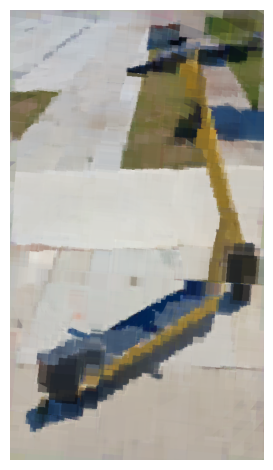

In [5]:
H,W = infos["H"], infos["W"]
fig,axes = plt.subplots(1,1)
# axes = axes.flatten()

axes.imshow(img_pred)
axes.axis('off')  # Hide axes for a cleaner look

plt.tight_layout()
plt.show()

In [120]:
# rotations = [Rotation.from_matrix(np.array(infos["fname_poseimagepath"][idx][0])[:3,:3]) for idx in range(len(infos["fname_poseimagepath"]))]
rotations = [Rotation.from_matrix(np.array(infos["fname_poseimagepath"][0][0])[:3,:3]),Rotation.from_matrix(np.array(infos["fname_poseimagepath"][1][0])[:3,:3])]
times = np.arange(2)

slerp = Slerp(times, Rotation.concatenate(rotations))

N = 100
new_times = np.linspace(0,2-1,N)
new_rots = slerp(new_times)
new_rots = new_rots.as_matrix()

t = new_times.reshape(1,-1)
translations = np.array(infos["fname_poseimagepath"][0][0])[:3,3].reshape(3,1) * (1-t) + np.array(infos["fname_poseimagepath"][1][0])[:3,3].reshape(3,1) * t

Htms = create_homogeneous_matrix(new_rots,translations.T)

In [128]:
images = []

for idx in range(N):
    ro,rd = initialize_rays(H,W,1800,1800, device=device)
    pose = torch.Tensor(Htms[idx])
    pose = torch.linalg.inv(pose)
    ro,rd = apply_camera_transformation(ro,rd,pose.to(device))

    im,alpha =  rendering([model],ro.to(device),rd.to(device)
                                            ,tn,tf, nb_bins,device=device)
    img_pred = im.reshape(H,W,-1).cpu().detach().numpy()

    images.append(img_pred)

    ro,rd=None,None
    gc.collect()
    torch.cuda.empty_cache()

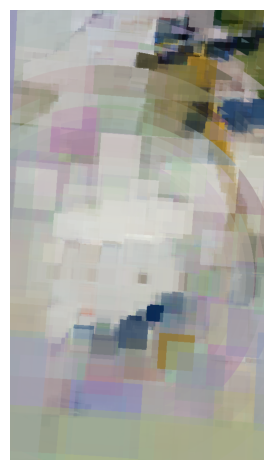

In [131]:
H,W = infos["H"], infos["W"]
fig,axes = plt.subplots(1,1)
# axes = axes.flatten()

axes.imshow(images[1])
axes.axis('off')  # Hide axes for a cleaner look

plt.tight_layout()
plt.show()

In [130]:
# Create a temporary directory to save the individual frames
with imageio.get_writer('output.gif', mode='I') as writer:
    for img in images:
        fig, ax = plt.subplots()
        ax.imshow(img)
        ax.axis('off')  # Turn off the axis
        plt.tight_layout()

        # Save the plot as an image and add it to the GIF
        fig.canvas.draw()
        frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
        frame = frame.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        writer.append_data(frame)

        plt.close(fig)  # Close the figure to free memory